# Sharpen with bilinear

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

In [13]:
from tensorflow.keras.layers import Input, Dense, ReLU, Add, Conv1D, BatchNormalization, LayerNormalization, Layer, Flatten, MaxPooling1D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras import losses
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from tensorflow.image import resize


### Set up for up and down scaling

In [14]:
def rationalConv(x, filters=16, kernel_size=(3,3), padding="same", start=7, end=3):
    """
    Where ordinary convolutions down-scale by an integer stride, 
    the rational version up-samples and down-scales an integer stride to 
    reach a desired rational upscaling.

    Example: 7 -> 3 => 7 * bilinear(9/7) = 9, 9 / conv(3) = 3
    """
    size = x.shape
    stride = np.ceil(start/end).astype(int)
    scaling = (end*stride)/start
    
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    if stride > 1:
        x = Conv2D(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    return x

def rationalConvTransposed(x, filters=16, kernel_size=(3,3), padding="same", start=3, end=7):
    """
    Where ordinary transposed convolutions up-scale by an integer stride, 
    the rational version up-scales an integer stride and down-samples to 
    reach a desired rational upscaling.
    
    Example: 3 -> 7 => 3 * convTr(3) = 9, 9 * bilinear(7/9) = 7
    """
    size = x.shape
    stride = np.ceil(end/start).astype(int)
    scaling = end/start
    
    if stride > 1:
        x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides = (stride,stride), padding=padding)(x)
    x = resize(x, tf.constant(np.round([size[1]*scaling, size[2]*scaling]), dtype="int32"))
    return x

In [21]:

input_img = Input(shape=(30,30,3))
x = rationalConvTransposed(input_img, end=7, start=3)
x = Conv2D(8, kernel_size=3, padding="same", activation='relu')(x)
x = Conv2D(3, kernel_size=3, padding="same", activation='relu')(x)

model = Model(inputs = [input_img], outputs = [x])
model.compile(optimizer='adam',
              loss='mse')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 30, 30, 3)]       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 90, 90, 16)        448       
_________________________________________________________________
tf.image.resize_3 (TFOpLambd (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 70, 70, 8)         1160      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 70, 70, 3)         219       
Total params: 1,827
Trainable params: 1,827
Non-trainable params: 0
_________________________________________________________________


In [16]:
X = np.load("X_data.npy")
y = np.load("y_data.npy")

In [17]:
y.shape

(50, 70, 70, 3)

In [22]:
h = model.fit(X,y,epochs=10)

Epoch 1/10
2/2 [==============================] - 1s 112ms/step - loss: 0.0841
Epoch 2/10
2/2 [==============================] - 0s 125ms/step - loss: 0.0817
Epoch 3/10
2/2 [==============================] - 0s 135ms/step - loss: 0.0756
Epoch 4/10
2/2 [==============================] - 0s 110ms/step - loss: 0.0696
Epoch 5/10
2/2 [==============================] - 0s 163ms/step - loss: 0.0646
Epoch 6/10
2/2 [==============================] - 0s 126ms/step - loss: 0.0576
Epoch 7/10
2/2 [==============================] - 0s 121ms/step - loss: 0.0489
Epoch 8/10
2/2 [==============================] - 0s 158ms/step - loss: 0.0423
Epoch 9/10
2/2 [==============================] - 0s 111ms/step - loss: 0.0339
Epoch 10/10
2/2 [==============================] - 0s 125ms/step - loss: 0.0279


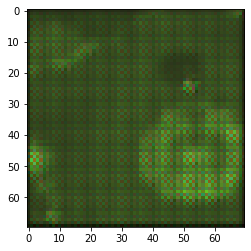

In [23]:
plt.imshow(model.predict(X[0:1])[0])